In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install kaggle

In [6]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.32G/1.33G [00:08<00:00, 229MB/s]
100% 1.33G/1.33G [00:08<00:00, 170MB/s]


In [7]:
import zipfile

with zipfile.ZipFile("/content/celeba-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [9]:
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

In [10]:
# File paths
BASIC_PATH = "/content/dataset"
IMG_PATH = os.path.join(BASIC_PATH, 'img_align_celeba/img_align_celeba')
FEATURE_PATH = os.path.join(BASIC_PATH, 'list_attr_celeba.csv')

In [11]:
# Membaca jumlah gambar di direktori
n_images = len(os.listdir(IMG_PATH))
print("Total Images in the Dataset: ", n_images)

Total Images in the Dataset:  202599


In [12]:
# Membaca file csv atribut ke dalam dataframe
df = pd.read_csv(FEATURE_PATH, usecols=['image_id','Male'])
df = df.sample(n=2500, random_state = 42).reset_index(drop=True)

# Mengubah nilai kolom 'Male' menjadi kategorik
df.loc[df['Male'] == -1,'Male'] = "Female"
df.loc[df['Male'] == 1,'Male'] = "Male"

<ipython-input-12-d8b3b1417418>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Female' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Male'] == -1,'Male'] = "Female"


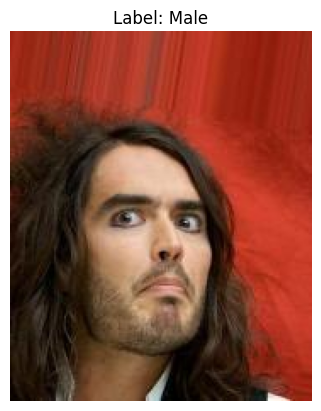

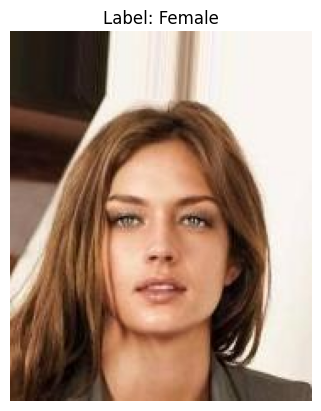

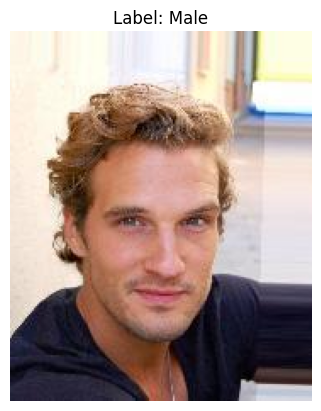

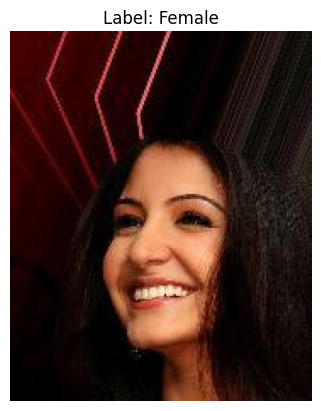

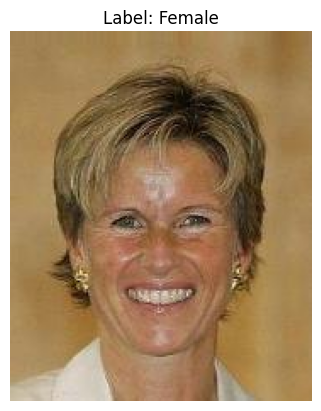

In [13]:
# prompt: Sample Images

def show_sample_images(df, img_path, num_images=5):
  """
  Displays sample images with their corresponding labels.

  Args:
    df: Pandas DataFrame containing image IDs and labels.
    img_path: Path to the directory containing images.
    num_images: Number of sample images to display.
  """
  for i in range(num_images):
    image_id = df['image_id'][i]
    image_path = os.path.join(img_path, image_id)
    label = df['Male'][i]

    try:
      img = mpimg.imread(image_path)
      plt.imshow(img)
      plt.title(f"Label: {label}")
      plt.axis('off')
      plt.show()
    except FileNotFoundError:
      print(f"Image not found: {image_path}")

# Example usage
show_sample_images(df, IMG_PATH)

In [14]:
# prompt: # Get the category distribution.
category_counts = df['Male'].value_counts()
print("Category Distribution:")
print(category_counts)

Category Distribution:
Male
Female    1442
Male      1058
Name: count, dtype: int64


In [15]:
# prompt: Get the indices of the higher category indices images. and  # Drop the extra rows of female images to fix class imbalance problem.

# Get the indices of the higher category (e.g., 'Male')
higher_category_indices = df[df['Male'] == 'Male'].index.tolist()

# Drop the extra rows of female images to fix class imbalance problem.
# (You might want to adjust the number of dropped rows or use a different strategy based on your specific needs).
num_to_drop = len(df[df['Male'] == 'Female']) - len(df[df['Male'] == 'Male'])

if num_to_drop > 0:
  female_indices = df[df['Male'] == 'Female'].index.tolist()
  indices_to_drop = np.random.choice(female_indices, size=num_to_drop, replace=False)
  df = df.drop(indices_to_drop)

# Verify the updated category counts
category_counts = df['Male'].value_counts()
print("Updated Category Distribution:")
print(category_counts)

Updated Category Distribution:
Male
Male      1058
Female    1058
Name: count, dtype: int64


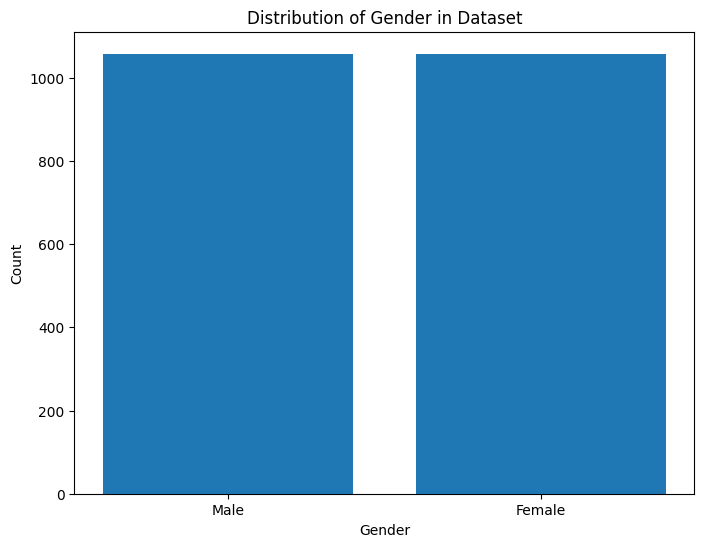

In [16]:

# Assuming 'category_counts' is the variable containing the distribution of 'Male'
category_counts = df['Male'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Distribution of Gender in Dataset")
plt.show()

In [17]:
# prompt: Train, Test, and Validation Split

# Split the data into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Male'])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['Male'])  # 0.25 x 0.8 = 0.2

# Print the shapes of the resulting sets
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Testing set shape:", test_df.shape)

# You can now use train_df, val_df, and test_df for training, validation, and testing your model

Training set shape: (1269, 2)
Validation set shape: (423, 2)
Testing set shape: (424, 2)


In [18]:
# prompt: Create Image Data Generators for train and validation data

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_PATH,
    x_col="image_id",
    y_col="Male",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMG_PATH,
    x_col="image_id",
    y_col="Male",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 1269 validated image filenames belonging to 2 classes.
Found 423 validated image filenames belonging to 2 classes.


In [19]:
# prompt: VGG16 model

# Load the pre-trained VGG16 model (excluding the top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# Create a new model on top of the base model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification (Male/Female)
])

In [22]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # You can adjust the number of epochs
    validation_data=validation_generator
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - accuracy: 0.6018 - loss: 0.6795 - val_accuracy: 0.7494 - val_loss: 0.4588
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.7356 - loss: 0.5149 - val_accuracy: 0.8652 - val_loss: 0.3467
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step - accuracy: 0.8124 - loss: 0.4194 - val_accuracy: 0.8794 - val_loss: 0.3177
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.8330 - loss: 0.3668 - val_accuracy: 0.8842 - val_loss: 0.3037
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.8483 - loss: 0.3760 - val_accuracy: 0.8818 - val_loss: 0.2969
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - accuracy: 0.8381 - loss: 0.3638 - val_accuracy: 0.8842 - val_loss: 0.2871
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.8505 - loss: 0.3689 - val_accuracy: 0.8936 - val_loss: 0.2837
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.8708 - loss: 0.3242 - val_accuracy: 0.891

In [24]:
# Evaluate the model on the testing set
# Create a test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMG_PATH,
    x_col="image_id",
    y_col="Male",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for getting predictions in the correct order
)

Found 424 validated image filenames belonging to 2 classes.


In [25]:
# Get predictions
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step


In [26]:
# Get true labels
y_true = test_generator.classes

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy * 100, "%")  # Print accuracy as percentage

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.8925 - loss: 0.2669
Test Loss: 0.2704320549964905
Test Accuracy: 88.44339847564697 %


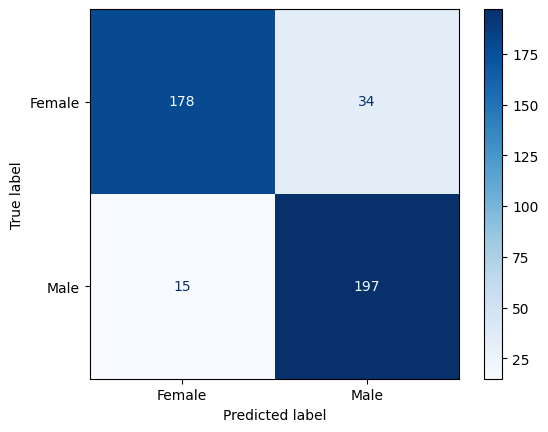

In [28]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [31]:
# prompt: save the model
model.save('VGG_MODEL.keras')

In [30]:
# prompt: print jumlah dataset yang digunakan dan label , dan juga lakukan anlisis dari hasil akuracy

print("Jumlah dataset yang digunakan:", len(df))
print("Label (Gender):", df['Male'].unique())

# Analisis akurasi
print("Test Accuracy:", accuracy * 100, "%")

# Analisis Confusion Matrix
print("Confusion Matrix:")
print(cm)
print("\nTrue Positives (TP):", cm[1][1]) # Male correctly classified as Male
print("True Negatives (TN):", cm[0][0]) # Female correctly classified as Female
print("False Positives (FP):", cm[0][1]) # Female incorrectly classified as Male
print("False Negatives (FN):", cm[1][0]) # Male incorrectly classified as Female

# Menghitung precision, recall, dan F1-score
precision = cm[1][1] / (cm[1][1] + cm[0][1])
recall = cm[1][1] / (cm[1][1] + cm[1][0])
f1_score = 2 * (precision * recall) / (precision + recall)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

# Tambahan analisis
if accuracy > 0.8:
    print("\nModel memiliki akurasi yang tinggi, menunjukkan kemampuan yang baik dalam mengklasifikasikan gender.")
elif accuracy > 0.6:
    print("\nModel memiliki akurasi yang cukup baik, tetapi masih ada ruang untuk peningkatan.")
else:
    print("\nModel memiliki akurasi yang rendah, perlu dilakukan perbaikan pada model atau dataset.")

if cm[0][1] > cm[1][0]:
    print("\nModel cenderung lebih sering salah mengklasifikasikan perempuan sebagai laki-laki.")
elif cm[1][0] > cm[0][1]:
    print("\nModel cenderung lebih sering salah mengklasifikasikan laki-laki sebagai perempuan.")
else:
    print("\nModel cenderung salah mengklasifikasikan kedua kelas dengan jumlah yang seimbang.")



# Hitung jumlah dataset Male dan Female
male_count = df[df['Male'] == 'Male'].shape[0]
female_count = df[df['Male'] == 'Female'].shape[0]

print("Jumlah dataset Male:", male_count)
print("Jumlah dataset Female:", female_count)

# prompt: print pembagian dataset data traning dan data uji dalam %

# Print the percentage of training and testing data
print("Percentage of training data:", round((len(train_df) / len(df)) * 100, 2), "%")
print("Percentage of validation data:", round((len(val_df) / len(df)) * 100, 2), "%")
print("Percentage of testing data:", round((len(test_df) / len(df)) * 100, 2), "%")

Jumlah dataset yang digunakan: 2116
Label (Gender): ['Male' 'Female']
Test Accuracy: 88.44339847564697 %
Confusion Matrix:
[[178  34]
 [ 15 197]]

True Positives (TP): 197
True Negatives (TN): 178
False Positives (FP): 34
False Negatives (FN): 15

Precision: 0.8528138528138528
Recall: 0.9292452830188679
F1-score: 0.8893905191873589

Model memiliki akurasi yang tinggi, menunjukkan kemampuan yang baik dalam mengklasifikasikan gender.

Model cenderung lebih sering salah mengklasifikasikan perempuan sebagai laki-laki.
Jumlah dataset Male: 1058
Jumlah dataset Female: 1058
Percentage of training data: 59.97 %
Percentage of validation data: 19.99 %
Percentage of testing data: 20.04 %
